In [1]:
import gc
import os
import time 
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from collections import defaultdict

In [2]:
pwd

'c:\\Users\\wangc\\Desktop\\Ashish Tele\\1. CLV python'

In [3]:
df = pd.read_csv('c:\\Users\\wangc\\Desktop\\Ashish Tele\\1. CLV python\\data.csv', encoding = "ISO-8859-1" )

# change InvoiceDate from object to datetime format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


## Processing Data

In [5]:
# Canceled orders have negative values, and should be removed. 
df = df.loc[df['Quantity'] > 0]
df.shape

(531285, 8)

In [6]:
# removing null customerID  
df = df[pd.notnull(df['CustomerID'])]
df.shape

(397924, 8)

In [7]:
# filtering the date to include full months only 
print('Invoice Date Range: %s - %s' % (df['InvoiceDate'].min(), df['InvoiceDate'].max()))
df = df.loc[df['InvoiceDate'] < '2011-12-01']

Invoice Date Range: 2010-12-01 08:26:00 - 2011-12-09 12:50:00


In [8]:
# creating a new column Sales
df['Sales'] = df['Quantity'] * df['UnitPrice']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [9]:
# Group the dataframe by CustomerID and InvoiceNo and aggregate the Sales column 
orders_df = df.groupby(['CustomerID', 'InvoiceNo']).agg({
    'Sales': sum, 
    'InvoiceDate': max
})
print(orders_df)

                         Sales         InvoiceDate
CustomerID InvoiceNo                              
12346.0    541431     77183.60 2011-01-18 10:01:00
12347.0    537626       711.79 2010-12-07 14:57:00
           542237       475.39 2011-01-26 14:30:00
           549222       636.25 2011-04-07 10:43:00
           556201       382.52 2011-06-09 13:01:00
...                        ...                 ...
18283.0    578262       313.65 2011-11-23 13:27:00
           579673       223.61 2011-11-30 12:59:00
18287.0    554065       765.28 2011-05-22 10:39:00
           570715      1001.32 2011-10-12 10:23:00
           573167        70.68 2011-10-28 09:29:00

[17758 rows x 2 columns]


C:\Users\wangc\AppData\Local\Temp\ipykernel_14720\1887397408.py:2: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  orders_df = df.groupby(['CustomerID', 'InvoiceNo']).agg({
C:\Users\wangc\AppData\Local\Temp\ipykernel_14720\1887397408.py:2: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  orders_df = df.groupby(['CustomerID', 'InvoiceNo']).agg({


In [10]:
# creating functions for descriptive part 
def groupby_mean(x):
    return x.mean()

def groupby_count(x):
    return x.count()

def purchase_duration(x):
    return (x.max() - x.min()).days

def avg_frequency(x):
    return(x.max() - x.min()).days / x.count()

groupby_mean.__name__ = 'avg'
groupby_count.__name__ = 'count'
purchase_duration.__name__ = 'purchase_duration'
avg_frequency.__name__ = 'purchase_frequency'

In [11]:
# group by CustomerID and aggregate the Sales & InvoiceDate along with the existing functions 
summary_df = orders_df.reset_index().groupby('CustomerID').agg({
    'Sales': [min, max, sum, groupby_mean, groupby_count],
    'InvoiceDate': [min, max, purchase_duration, avg_frequency]
})

summary_df.head()

C:\Users\wangc\AppData\Local\Temp\ipykernel_14720\1370303034.py:2: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  summary_df = orders_df.reset_index().groupby('CustomerID').agg({
C:\Users\wangc\AppData\Local\Temp\ipykernel_14720\1370303034.py:2: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  summary_df = orders_df.reset_index().groupby('CustomerID').agg({
C:\Users\wangc\AppData\Local\Temp\ipykernel_14720\1370303034.py:2: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pas

Sales                                          \
                 min       max       sum           avg count   
CustomerID                                                     
12346.0     77183.60  77183.60  77183.60  77183.600000     1   
12347.0       382.52   1294.32   4085.18    680.863333     6   
12348.0       227.44    892.80   1797.24    449.310000     4   
12349.0      1757.55   1757.55   1757.55   1757.550000     1   
12350.0       334.40    334.40    334.40    334.400000     1   

                   InvoiceDate                                        \
                           min                 max purchase_duration   
CustomerID                                                             
12346.0    2011-01-18 10:01:00 2011-01-18 10:01:00                 0   
12347.0    2010-12-07 14:57:00 2011-10-31 12:25:00               327   
12348.0    2010-12-16 19:09:00 2011-09-25 13:13:00               282   
12349.0    2011-11-21 09:51:00 2011-11-21 09:51:00                 0   
12350.0    2011-02-02 16:01:00 2011-02-02 16:01:00                 0   

                               
           purchase_frequency  
CustomerID                     
12346.0                   0.0  
12347.0                  54.5  
12348.0                  70.5  
12349.0                   0.0  
12350.0                   0.0

In [12]:
summary_df.columns = ['_'.join(col).lower() for col in summary_df.columns]
summary_df = summary_df.reset_index()
summary_df.head()

,CustomerID,sales_min,sales_max,sales_sum,sales_avg,sales_count,invoicedate_min,invoicedate_max,invoicedate_purchase_duration,invoicedate_purchase_frequency
0,12346.0,77183.60,77183.60,77183.60,77183.600000,1,2011-01-18 10:01:00,2011-01-18 10:01:00,0,0.0
1,12347.0,382.52,1294.32,4085.18,680.863333,6,2010-12-07 14:57:00,2011-10-31 12:25:00,327,54.5
2,12348.0,227.44,892.80,1797.24,449.310000,4,2010-12-16 19:09:00,2011-09-25 13:13:00,282,70.5
3,12349.0,1757.55,1757.55,1757.55,1757.550000,1,2011-11-21 09:51:00,2011-11-21 09:51:00,0,0.0
4,12350.0,334.40,334.40,334.40,334.400000,1,2011-02-02 16:01:00,2011-02-02 16:01:00,0,0.0


## Visualization

In [13]:
# we are interested in the purchases that the repeat customers have made
summary_df = summary_df.loc[summary_df['invoicedate_purchase_duration'] > 0]
summary_df.shape

(2692, 10)

In [14]:
# we have 2692 repeat customers in the record

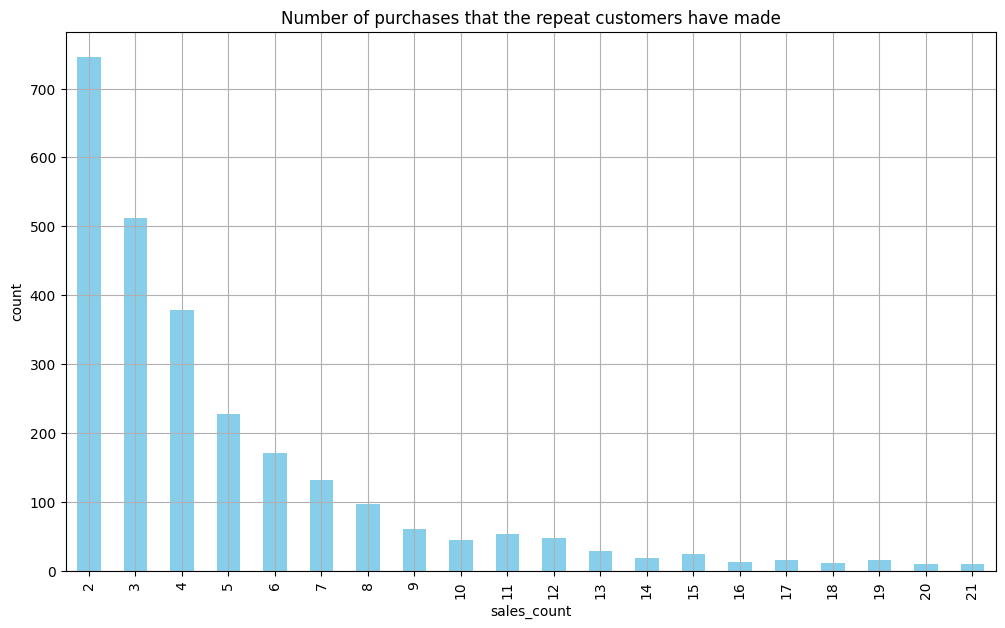

In [15]:
ax = summary_df.groupby('sales_count').count()['sales_avg'][:20].plot(
    kind = 'bar',
    color='skyblue',
    figsize=(12,7),
    grid = True
)

ax.set_ylabel('count')
plt.title('Number of purchases that the repeat customers have made')

plt.show()

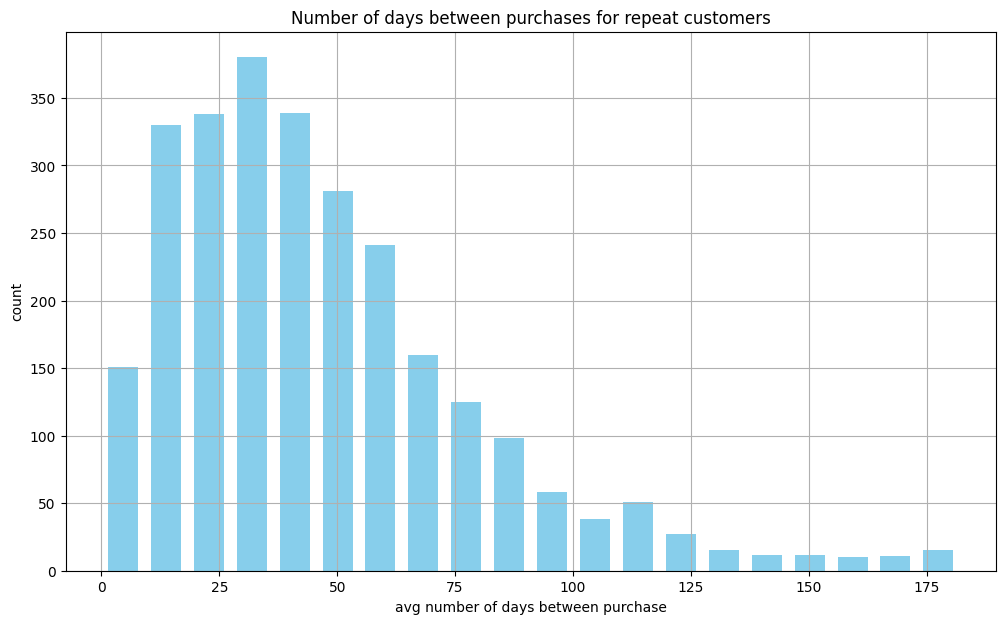

In [16]:
## average number of days between purchase for repeat customers. 
ax = summary_df['invoicedate_purchase_frequency'].hist(
    bins=20,
    color='skyblue',
    rwidth=0.7,
    figsize=(12,7)
)

ax.set_xlabel('avg number of days between purchase')
ax.set_ylabel('count')
plt.title('Number of days between purchases for repeat customers')

plt.show()

## Predicting 3-month CLV

In [17]:
clv_freq = '3M'

# group by customerID
# break down the data into chunks of 3 months for each customer
# aggregate the sales columns by sum
# aggregate the sales column by average_sum and count (both with the previous created functions)
data_df = orders_df.reset_index().groupby([
    'CustomerID',
    pd.Grouper(key='InvoiceDate', freq=clv_freq)
]).agg({
    'Sales': [sum, groupby_mean, groupby_count],
})

data_df.columns = ['_'.join(col).lower() for col in data_df.columns]
data_df = data_df.reset_index()
data_df.head()

C:\Users\wangc\AppData\Local\Temp\ipykernel_14720\1319070017.py:10: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  ]).agg({


,CustomerID,InvoiceDate,sales_sum,sales_avg,sales_count
0,12346.0,2011-03-31,77183.60,77183.600,1
1,12347.0,2010-12-31,711.79,711.790,1
2,12347.0,2011-03-31,475.39,475.390,1
3,12347.0,2011-06-30,1018.77,509.385,2
4,12347.0,2011-09-30,584.91,584.910,1


In [18]:
# encode the inviocedate column
 
length_of_InvoiceDate = 10 
date_month_map = {
    str(x)[:length_of_InvoiceDate]: 'M_%s' % (i+1) for i, x in enumerate( # directory comprehension 
        # convert each date to a string and slices it to the
        sorted(data_df.reset_index()['InvoiceDate'].unique(), reverse=True) # descending order
    )
}
date_month_map

{'2011-12-31': 'M_1',
 '2011-09-30': 'M_2',
 '2011-06-30': 'M_3',
 '2011-03-31': 'M_4',
 '2010-12-31': 'M_5'}

In [30]:
# apply the generated dictionary to the dataframe for prediction models
data_df['M'] = data_df['InvoiceDate'].apply(lambda x: date_month_map[str(x)[:length_of_InvoiceDate]])
data_df.head()

,CustomerID,InvoiceDate,sales_sum,sales_avg,sales_count,M
0,12346.0,2011-03-31,77183.60,77183.600,1,M_4
1,12347.0,2010-12-31,711.79,711.790,1,M_5
2,12347.0,2011-03-31,475.39,475.390,1,M_4
3,12347.0,2011-06-30,1018.77,509.385,2,M_3
4,12347.0,2011-09-30,584.91,584.910,1,M_2


## Modeling

In [ ]:
# create a sample set with features and target variables.
# Using the last 3 months as the target variable and the rest as the features.

In [34]:
# exclude M-1 because this will be our predictor variable. 
features_df = pd.pivot_table(
    data_df.loc[data_df['M']!= 'M_1'],
    values=['sales_sum', 'sales_avg', 'sales_count'],
    columns='M',
    index='CustomerID'
)

features_df.columns = ['_'.join(col) for col in features_df.columns]

features_df = features_df.fillna(0)
features_df

,sales_avg_M_2,sales_avg_M_3,sales_avg_M_4,sales_avg_M_5,sales_count_M_2,sales_count_M_3,sales_count_M_4,sales_count_M_5,sales_sum_M_2,sales_sum_M_3,sales_sum_M_4,sales_sum_M_5
CustomerID,,,,,,,,,,,,
12346.0,0.000000,0.000,77183.600000,0.00,0.0,0.0,1.0,0.0,0.00,0.00,77183.60,0.00
12347.0,584.910000,509.385,475.390000,711.79,1.0,2.0,1.0,1.0,584.91,1018.77,475.39,711.79
12348.0,310.000000,367.000,227.440000,892.80,1.0,1.0,1.0,1.0,310.00,367.00,227.44,892.80
12350.0,0.000000,0.000,334.400000,0.00,0.0,0.0,1.0,0.0,0.00,0.00,334.40,0.00
12352.0,316.250000,0.000,312.362000,0.00,2.0,0.0,5.0,0.0,632.50,0.00,1561.81,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
18280.0,0.000000,0.000,180.600000,0.00,0.0,0.0,1.0,0.0,0.00,0.00,180.60,0.00
18281.0,0.000000,80.820,0.000000,0.00,0.0,1.0,0.0,0.0,0.00,80.82,0.00,0.00
18282.0,100.210000,0.000,0.000000,0.00,1.0,0.0,0.0,0.0,100.21,0.00,0.00,0.00


In [37]:
# select M_1 as the target_variable
response_df = data_df.loc[
    data_df['M'] == 'M_1',
    ['CustomerID', 'sales_sum']
]
# rename the columns
response_df.columns = ['CustomerID', 'CLV_'+clv_freq]
response_df

,CustomerID,CLV_3M
5,12347.0,1294.32
10,12349.0,1757.55
14,12352.0,311.73
20,12356.0,58.35
21,12357.0,6207.67
...,...,...
9207,18274.0,175.92
9208,18276.0,335.86
9209,18277.0,110.38
9217,18283.0,766.21


In [38]:
# join the features_df and response_df on customerID
sample_set_df = features_df.merge(
    response_df,
    left_index=True,
    right_on='CustomerID',
    how='left'
)

sample_set_df = sample_set_df.fillna(0)
sample_set_df

,sales_avg_M_2,sales_avg_M_3,sales_avg_M_4,sales_avg_M_5,sales_count_M_2,sales_count_M_3,sales_count_M_4,sales_count_M_5,sales_sum_M_2,sales_sum_M_3,sales_sum_M_4,sales_sum_M_5,CustomerID,CLV_3M
NaN,0.000000,0.000,77183.600000,0.00,0.0,0.0,1.0,0.0,0.00,0.00,77183.60,0.00,12346.0,0.00
5.0,584.910000,509.385,475.390000,711.79,1.0,2.0,1.0,1.0,584.91,1018.77,475.39,711.79,12347.0,1294.32
NaN,310.000000,367.000,227.440000,892.80,1.0,1.0,1.0,1.0,310.00,367.00,227.44,892.80,12348.0,0.00
NaN,0.000000,0.000,334.400000,0.00,0.0,0.0,1.0,0.0,0.00,0.00,334.40,0.00,12350.0,0.00
14.0,316.250000,0.000,312.362000,0.00,2.0,0.0,5.0,0.0,632.50,0.00,1561.81,0.00,12352.0,311.73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NaN,0.000000,0.000,180.600000,0.00,0.0,0.0,1.0,0.0,0.00,0.00,180.60,0.00,18280.0,0.00
NaN,0.000000,80.820,0.000000,0.00,0.0,1.0,0.0,0.0,0.00,80.82,0.00,0.00,18281.0,0.00
NaN,100.210000,0.000,0.000000,0.00,1.0,0.0,0.0,0.0,100.21,0.00,0.00,0.00,18282.0,0.00
9217.0,92.696667,131.170,105.966667,0.00,3.0,4.0,3.0,0.0,278.09,524.68,317.90,0.00,18283.0,766.21


In [40]:
# train test split
target_var = 'CLV_'+clv_freq
all_features = [x for x in sample_set_df.columns if x not in ['CustomerID', target_var]]

In [42]:
target_var

'CLV_3M'

In [43]:
all_features

['sales_avg_M_2',
 'sales_avg_M_3',
 'sales_avg_M_4',
 'sales_avg_M_5',
 'sales_count_M_2',
 'sales_count_M_3',
 'sales_count_M_4',
 'sales_count_M_5',
 'sales_sum_M_2',
 'sales_sum_M_3',
 'sales_sum_M_4',
 'sales_sum_M_5']

In [44]:
trainX, testX, trainY, testY  = train_test_split(
    sample_set_df[all_features], 
    sample_set_df[target_var], 
    test_size=0.3
)

In [45]:
lm = LinearRegression()
lm.fit(trainX, trainY)

LinearRegression()

In [46]:
coef = pd.DataFrame(list(zip(all_features, lm.coef_)))
coef.columns = ['feature', 'Coefficient']

coef

,feature,Coefficient
0,sales_avg_M_2,0.363527
1,sales_avg_M_3,-0.651003
2,sales_avg_M_4,-0.105307
3,sales_avg_M_5,0.071731
4,sales_count_M_2,106.655531
5,sales_count_M_3,6.400715
6,sales_count_M_4,-91.488656
7,sales_count_M_5,-50.107287
8,sales_sum_M_2,0.205252
9,sales_sum_M_3,0.481190


In [47]:
y_pred = lm.predict(testX)

print('Mean Absolute Error:', metrics.mean_absolute_error(testY, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(testY, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(testY, y_pred)))

Mean Absolute Error: 403.1059362807836
Mean Squared Error: 747645.637570604
Root Mean Squared Error: 864.6650435692447


reference: https://github.com/hyunjoonbok/Python-Projects/blob/master/GeneralML/Cohort_Basket_Analysis/Measuring%20Customer%20Lifetime%20Value%20(LTV)%20in%20Python.ipynb